In [13]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 52.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [14]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

sns.set(style="whitegrid")

In [15]:
clientes = pd.read_csv("../datos/clientes.csv")
comentarios = pd.read_csv("../datos/comentarios.csv")
productos = pd.read_csv("../datos/productos.csv")

In [16]:
df = comentarios.merge(clientes, on="id_cliente", how="left")
df = df.merge(productos[["id_producto", "nombre_producto", "categoria"]], on="id_producto", how="left")

df["fecha_comentario"] = pd.to_datetime(df["fecha_comentario"], errors="coerce", format="mixed")
df = df.dropna(subset=["fecha_comentario"]).copy()

df.head()

,id_comentario,id_cliente,id_producto,calificacion,texto_comentario,fecha_comentario,nombre,email,ciudad,pais,fecha_registro,nombre_producto,categoria
0,1,1,2,5,El Smartphone Nexus 5G es un cambio de juego. ...,2024-05-20,Ana Martínez,ana.m@email.com,Madrid,España,2024-05-10,Smartphone Nexus 5G,Electrónica
1,2,2,4,4,La Camiseta Deportiva Ultralight es muy cómoda...,2024-05-21,Carlos Sánchez,carlos.s@email.com,Ciudad de México,México,2024-05-11,Camiseta Deportiva Ultralight,Ropa
2,3,3,1,5,La Laptop Gamer Pro es una bestia de rendimien...,2024-05-22,María López,maria.l@email.com,Bogotá,Colombia,2024-05-12,Laptop Gamer Pro,Electrónica
3,4,4,5,3,Las Zapatillas Urbanas Fit tienen un diseño mu...,2024-05-23,Jorge García,jorge.g@email.com,Buenos Aires,Argentina,2024-05-13,Zapatillas Urbanas Fit,Ropa
4,5,5,3,4,Los Auriculares Inalámbricos X ofrecen un soni...,2024-05-24,Valentina Pérez,valentina.p@email.com,Santiago,Chile,2024-05-14,Auriculares Inalámbricos X,Electrónica


In [17]:
print("Calculando sentimiento con nlptown (etiquetas 1-5 stars)... esto descarga/usa un modelo HF y puede tardar.")
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device=-1)
results = sentiment_analyzer(df["texto_comentario"].tolist(), truncation=True)
df["sentimiento_label"] = [r["label"] for r in results]
df["sentimiento_score_raw"] = [r["score"] for r in results]

def extract_stars(label):
    m = re.search(r"(\d)", str(label))
    return int(m.group(1)) if m else None

df["sentimiento_estrellas"] = df["sentimiento_label"].apply(extract_stars)

def star_to_polarity(s):
    if pd.isna(s):
        return None
    s = int(s)
    if s <= 2:
        return -1
    elif s == 3:
        return 0
    else:
        return 1

df["sentimiento_polaridad"] = df["sentimiento_estrellas"].apply(star_to_polarity)

print("Cargando spaCy (es_core_news_sm) y preprocesando textos...")
nlp = spacy.load("es_core_news_sm", disable=["ner", "parser"])  # solo tokenización/lemmatización/stopwords

def preprocess_spacy(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)  # eliminar urls
    text = re.sub(r"[^a-záéíóúñü\s]", " ", text)  # mantener caracteres en español
    doc = nlp(text)
    tokens = [
        token.lemma_.strip()
        for token in doc
        if not token.is_stop
           and not token.is_punct
           and not token.like_num
           and len(token.lemma_.strip()) > 2
    ]
    if not tokens:
        tokens = [w for w in text.split() if len(w) > 2]
    return " ".join(tokens)

df["texto_limpio"] = df["texto_comentario"].apply(preprocess_spacy)

Calculando sentimiento con nlptown (etiquetas 1-5 stars)... esto descarga/usa un modelo HF y puede tardar.


Device set to use cpu


Cargando spaCy (es_core_news_sm) y preprocesando textos...


In [18]:
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = embedding_model.encode(df["texto_limpio"].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 20/20 [00:00<00:00, 91.90it/s]


In [19]:
topic_model = BERTopic(
    embedding_model=embedding_model,  # opcional, pero lo ponemos por coherencia
    language="spanish",
    min_topic_size=2,   # con pocos datos pon 1 o 2; con datos grandes subir
    verbose=False
)

topics, probs = topic_model.fit_transform(df["texto_limpio"].tolist(), embeddings)
df["topic"] = topics

topic_info = topic_model.get_topic_info()  # puede tener 'Topic' o 'topic' según versión
topic_col = "topic" if "topic" in topic_info.columns else "Topic"

# crear columna mes (para suavizar series temporales)
df["mes"] = df["fecha_comentario"].dt.to_period("M").dt.to_timestamp()

# Sentimiento promedio (polaridad) por tópico, país y mes
sentiment_time_country = (
    df.groupby(["topic", "pais", "mes"])["sentimiento_polaridad"]
      .mean()
      .reset_index()
      .rename(columns={"sentimiento_polaridad": "sentimiento_promedio"})
)

# Agregar sentimiento promedio por topic al topic_info
topic_sentiment = df.groupby("topic")["sentimiento_polaridad"].mean().reset_index().rename(columns={"sentimiento_polaridad": "sentimiento_promedio_topic"})
topic_info = topic_info.merge(topic_sentiment, left_on=topic_col, right_on="topic", how="left")
topic_info.drop(columns=["topic"], inplace=True, errors="ignore")

print("\n=== Resumen de tópicos (Name + avg sentiment) ===")
display_cols = [c for c in [topic_col, "Name", "sentimiento_promedio_topic"] if c in topic_info.columns]
print(topic_info[display_cols].to_string(index=False))


=== Resumen de tópicos (Name + avg sentiment) ===
 Topic                                             Name  sentimiento_promedio_topic
    -1                    -1_cocina_calor_uniforme_olla                    0.625000
     0              0_sonido_comodidad_música_auricular                    0.607143
     1                   1_durabilidad_agarre_balón_top                    1.000000
     2           2_sonido_auricular_cancelación_estable                    0.823529
     3          3_lástima_agotar_portabilidad_increíble                   -0.062500
     4            4_nexus_smartphonir_teléfono_encantar                    1.000000
     5          5_interesante_libro_entretenido_lectura                    0.187500
     6               6_genial_estabilización_duro_fácil                    1.000000
     7                   7_borroso_general_video_acción                    0.733333
     8               8_ejercicio_camiseta_secar_retener                    1.000000
     9                 9_

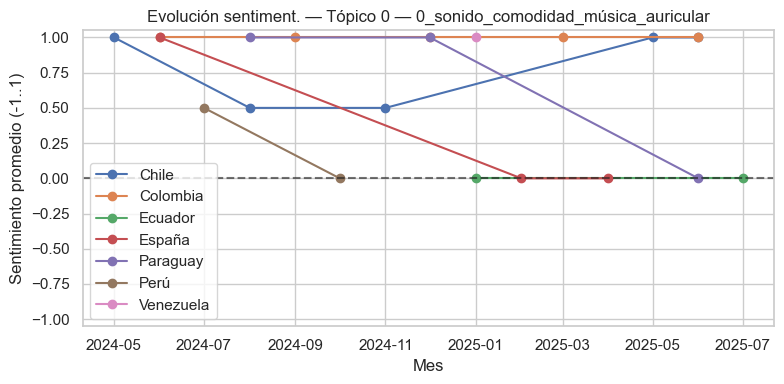

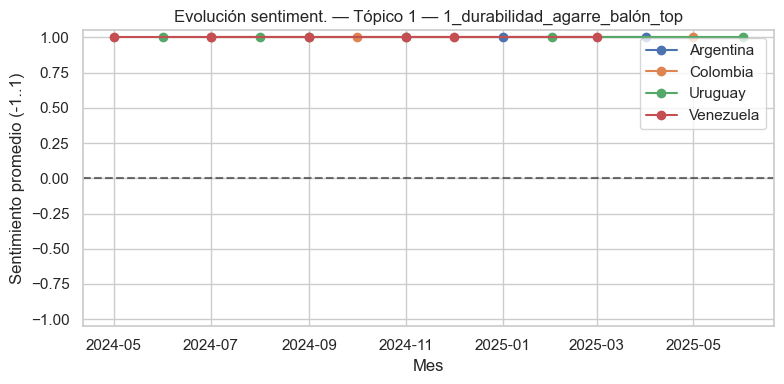

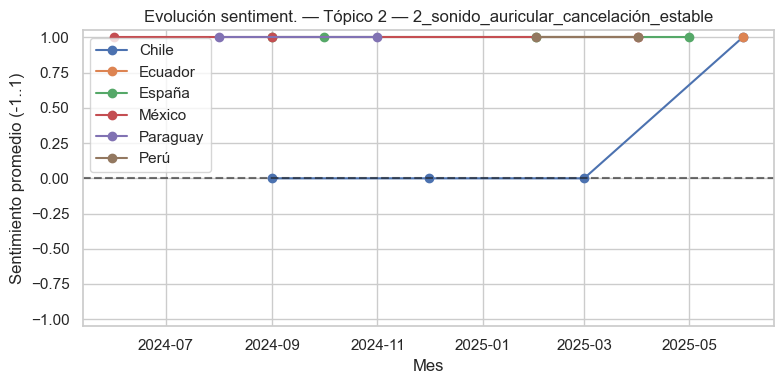

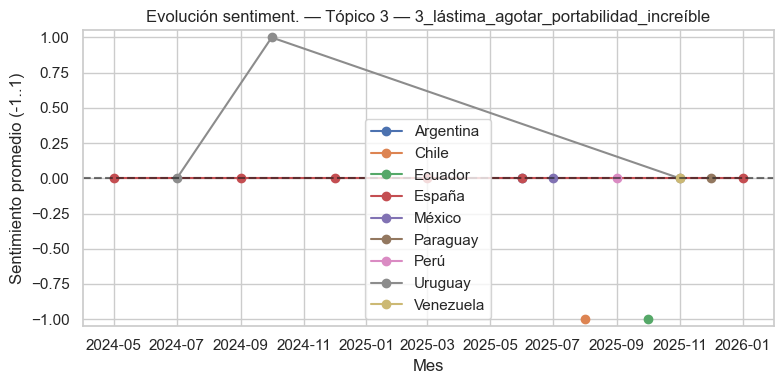

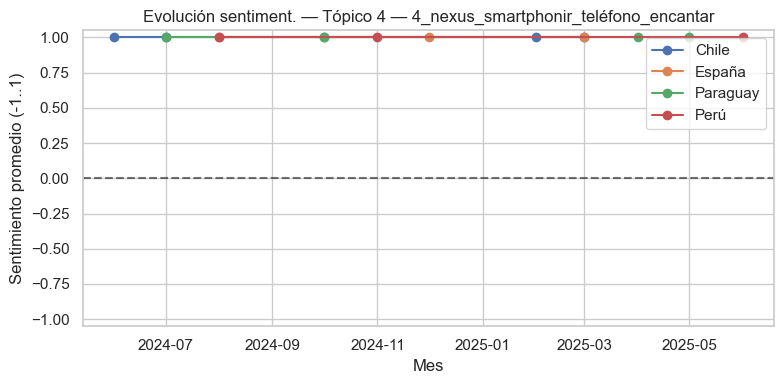

In [21]:
unique_topics = sorted([t for t in sentiment_time_country["topic"].unique() if t != -1])

for topic_id in unique_topics[:5]:  # mostrar solo los primeros 5 tópicos
    df_topic = sentiment_time_country[sentiment_time_country["topic"] == topic_id]
    if df_topic.empty:
        continue
    plt.figure(figsize=(8, 4))
    for pais in df_topic["pais"].unique():
        sub = df_topic[df_topic["pais"] == pais].sort_values("mes")
        plt.plot(sub["mes"], sub["sentimiento_promedio"], marker="o", label=pais)
    plt.axhline(0, color="k", linestyle="--", alpha=0.6)
    plt.ylim(-1.05, 1.05)
    # obtener nombre legible del tópico
    top_terms = topic_model.get_topic(topic_id)
    name = topic_info.loc[topic_info[topic_col] == topic_id, "Name"].values
    title_name = name[0] if len(name) else str(top_terms)[:60]
    plt.title(f"Evolución sentiment. — Tópico {topic_id} — {title_name}")
    plt.xlabel("Mes")
    plt.ylabel("Sentimiento promedio (-1..1)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [22]:
print("\n=== Ejemplos por tópico ===")
for topic_id in unique_topics:
    if topic_id == -1:
        continue
    top_words = topic_model.get_topic(topic_id)
    ejemplos = df[df["topic"] == topic_id].sort_values("fecha_comentario").head(3)["texto_comentario"].tolist()
    print(f"\nTópico {topic_id} — palabras: {top_words}")
    for i, ex in enumerate(ejemplos, 1):
        print(f"  {i}) {ex[:220]}{'...' if len(ex) > 220 else ''}")


=== Ejemplos por tópico ===

Tópico 0 — palabras: [('sonido', np.float64(0.09246534472505975)), ('comodidad', np.float64(0.08032115034670867)), ('música', np.float64(0.07914107246018301)), ('auricular', np.float64(0.06444488626868344)), ('hora', np.float64(0.051746750183716626)), ('cancelación', np.float64(0.04795890273781208)), ('fidelidad', np.float64(0.04635175424440025)), ('espectacular', np.float64(0.04635175424440025)), ('estable', np.float64(0.046165625601773425)), ('insuperable', np.float64(0.045415741019131636))]
  1) Los Auriculares Inalámbricos X ofrecen un sonido nítido y potente. La conexión Bluetooth es estable y no se interrumpe, lo cual es muy importante para mí. La única pega es que la cancelación de ruido no es tan efectiva e...
  2) El mejor par de auriculares que he tenido. La calidad de audio es espectacular, y la almohadilla es muy suave y cómoda, perfecta para largas sesiones de música o videollamadas. La cancelación de ruido funciona muy bien e...
  3) El sonid